# Meter Swapping Detection

Electricity theft is a huge problem for the Energy industry and a well-known and documented technique to steal energy is meter-swapping. Imagine two electricity consumers $A$ and $B$. Consumer $A$ is energy-efficient and do not consume a lot of electric energy, while household $B$ is a heavy consumer of electricity: he could be playing videogames too much, run the dishwasher 6 times a days or keep air conditioning on all the time. Now suppose that $B$ is a criminal mastermind and decides to switch his/her meter with that of $A$, this way he/she will effectively pay for $A$ small consumption, while $A$ will start receiving astronomical utility bills. 

A new paper by Zhu, Y. et al. (2020) [1] suggests that the Matrix Profile can be used to easily detect meter-swapping. In this tutorial we are going to use a dataset household electrical power demand collected from
twenty houses in the UK, which you can download from [here](https://pureportal.strath.ac.uk/en/datasets/refit-electrical-load-measurements-cleaned) [2]. The dataset records electricity consumption every 6-8 seconds between 2013 and 2015.

## Load Libraries

In [203]:
!pip install stumpy

In [204]:
%matplotlib inline

import stumpy
import pandas as pd
import numpy as np
from zipfile import ZipFile
from io import BytesIO
import os
import requests
import matplotlib.pyplot as plt
import datetime

plt.rcParams["figure.figsize"] = [20, 6]  # width, height
plt.rcParams['xtick.direction'] = 'out'

np.random.seed(1337)  # Random seed for reproducibility

## Load and clean data

For each house, the dataset measures aggregate electricity consumption and single appliances' consumption. Because in our case we won't need to look at appliances, we will only load the `Aggregate` column. Also, loading data of all the 20 houses recorded in the study would be too heavy in terms of computations and it is not necessary to reproduce  the experiment of Zhu, Y. et al. (2020) [1]. Thus, we will only load data for House 1, 2, 3, 4 and 11.

In [206]:
#load data from Drive 
path = os.path.join("/content/drive/My Drive/", "consumption") 
filenames = [f"CLEAN_House{i}.csv" for i in [1,2,3,4,11]]

#load data into DataFrames and put them into a dictionary
consumptions = {}
for house in filenames:
    consumptions[house] = pd.read_csv(os.path.join(path, house), usecols=[0, 2])

In [207]:
#rename dictionary keys for easy access
for key in list(consumptions.keys()):
    consumptions[key[6:-4]] = consumptions.pop(key)
list(consumptions.keys())

['House1', 'House2', 'House3', 'House4', 'House11']

In [208]:
#convert column 'Time' to datetime format and sort dfs by date
for i in [1,2,3,4,11]:
    consumptions[f"House{i}"]["Time"] = pd.to_datetime(
        consumptions[f"House{i}"]["Time"], infer_datetime_format=True
    )
    consumptions[f"House{i}"] = consumptions[f"House{i}"].sort_values(by=["Time"])

Now we can look at our dataframe. As we can see, we only have two columns: `Time` and `Aggregate`

In [209]:
consumptions['House1'].head()

,Time,Aggregate
0,2013-10-09 13:06:17,523
1,2013-10-09 13:06:31,526
2,2013-10-09 13:06:46,540
3,2013-10-09 13:07:01,532
4,2013-10-09 13:07:15,540


FIrst of all, for our example we are going to take a subset of the data that goes from the 1st of May till the 23rd of December. We can easily filter all the 5 Houses DataFrames.

In [210]:
startdate = "2014-01-01"
enddate = "2014-12-31"

for i in [1,2,3,4,11]:
  mask = (consumptions[f'House{i}'].Time >= startdate) & (consumptions[f'House{i}'].Time <= enddate)
  consumptions[f'House{i}'] = consumptions[f"House{i}"][mask]

Let's finally plot our consumption data

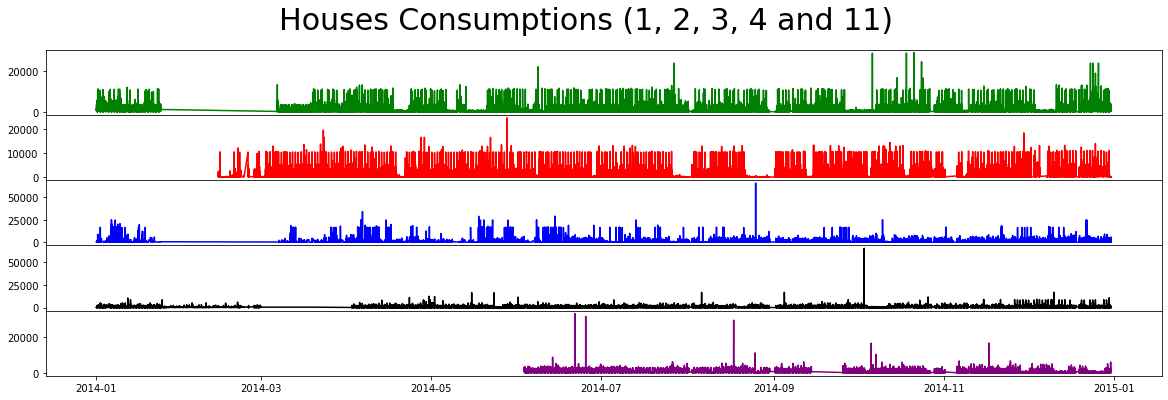

In [211]:
fig, axs = plt.subplots(5, sharex=True, gridspec_kw={"hspace": 0})
plt.suptitle("Houses Consumptions (1, 2, 3, 4 and 11)", fontsize="30")

ax = 0
colors = ['green', 'red', 'blue', 'black', 'purple']

for i, c in zip([1,2,3,4,11], colors):
  axs[ax].plot(consumptions[f"House{i}"]["Time"], consumptions[f"House{i}"]["Aggregate"], color = c)
  ax += 1 

In [212]:
#length of our dataframes
for i in [1,2,3,4,11]: print(len(consumptions[f"House{i}"]))

3835951
3575231
4028495
3838129
2488428


The electricity consumption data in our dataset is recorded every 6 to 8 seconds. Thus, each time series contains around 2.5 million data points. Although this provides high accuracy, it would take too much time to compute the matrix profiles of these time series. A simple solution is to use pandas `resample()`, a Convenience method for frequency conversion and resampling of time series. Thanks to this function we can resample our data to 5 minutes periods, dramatically reducing the size of our dataframes.

In [213]:
#resample data by grouping in 5 minute periods and take the mean.
for i in [1,2,3,4,11]:
  consumptions[f"House{i}"].set_index('Time',inplace=True)
  consumptions[f"House{i}"] = consumptions[f"House{i}"].resample('H').mean()
  consumptions[f"House{i}"].reset_index(level=0, inplace=True)

print('New length of DataFrames')
for i in [1,2,3,4,11]: print(len(consumptions[f"House{i}"]))

New length of DataFrames
8736
7688
8736
8736
5053


## Meter-swapping detection

In order to simulate a meter-swapping event, we can randomly select two time series and swap their traces starting at October 1st. We are also going to compute Heads and Tails (consumption before and after October 1st) for all the other time series.

In [214]:
#function to compute all heads and tails
def heads_tails(cutoff):
  heads, tails = {}, {}
  for i in [1,2,3,4,11]:
    heads[f'H_{i}'] = consumptions[f'House{i}'][consumptions[f'House{i}'].Time < cutoff]
    tails[f'T_{i}'] = consumptions[f'House{i}'][consumptions[f'House{i}'].Time >= cutoff]
  return heads, tails

heads, tails = heads_tails(cutoff = "2014-10-01")

#swap Heads and Tails of 1 and 11
swap1, swap2 = 1, 11
consumptions[f'House{swap1}'] = heads[f'H_{swap1}'].append(tails[f'T_{swap2}'])
consumptions[f'House{swap2}'] = heads[f'H_{swap2}'].append(tails[f'T_{swap1}'])
heads, tails = heads_tails(cutoff = "2014-10-01") #compute heads and tails again

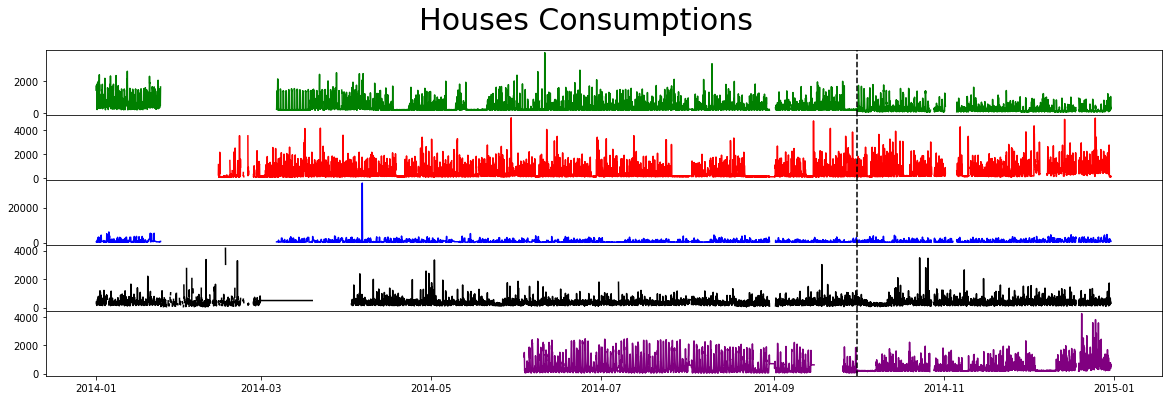

In [215]:
#plot after swap
fig, axs = plt.subplots(5, sharex=True, gridspec_kw={"hspace": 0})
plt.suptitle("Houses Consumptions", fontsize="30")

ax = 0
colors = ['green', 'red', 'blue', 'black', 'purple']
for i, c  in zip([1,2,3,4,11], colors):
    axs[ax].plot(consumptions[f"House{i}"]["Time"], consumptions[f"House{i}"]["Aggregate"], color = c)
    axs[ax].axvline(x=datetime.date(2014, 10, 1), linestyle="dashed", color = 'black')
    ax += 1 

It is pretty clear from the above plot that it is pretty difficult to detect meter-swapping thefts by naked eye. In order to detect the swapped Heads and Tails we can implement a simple algorithm that leverages the power of the Matrix Profile. 

We join all possible combinations of Heads and Tails, and record the pair $H_{i}$, $H_{j}$ that minimizes the following score:

$\text { Swap-Score }(i, j)=\min \left(\operatorname{Head}_{\mathrm{H} i} \bowtie_\theta 1 \text { nn Tail }_{H j}\right) /\left(\min \left(\operatorname{Head}_{\mathrm{H} i} \bowtie \theta 1 \text { nn Tail }_{H i}\right)+\text { epsilon }\right)$


 $\left(\operatorname{Head}_{\mathrm{H} i} \bowtie \theta 1 \text { nn Tail }_{H j}\right)$ is a vector of Euclidean distances between subsequences of $\operatorname{Head}_{\mathrm{H} i}$ and its nearest neighbor in $\operatorname{Tail}_{\mathrm{H} j}$. 

$\left(\operatorname{Head}_{\mathrm{H} i} \bowtie \theta 1 \text { nn Tail }_{H i}\right)$ is a vector of Euclidean distances between subsequences of $\operatorname{Head}_{\mathrm{H} i}$ and its nearest neighbor in $\operatorname{Tail}_{\mathrm{H} i}$

The equation looks a bit scary but the implementation in code will make things clearer.



In [216]:
from numba import cuda
m = 24 * 4#

min_score = {}
for i in [1,2,3,4,11]:
  H_i, T_i = heads[f'H_{i}'].iloc[:, 1].astype(float), tails[f'T_{i}'].iloc[:, 1].astype(float)
  mp = stumpy.stump(T_i, m, H_i, ignore_trivial=False)
  mp_min = np.nanmin(mp[:, 0]) + 0.001
  mp[mp == np.inf] = np.nan

  for j in [1,2,3,4,11]:
    T_j = tails[f'T_{j}'].iloc[:, 1].astype(float)
    mp_j = stumpy.stump(T_j, m, H_i, ignore_trivial=False)
    mp_j_min = np.nanmin(mp_j[:, 0])
    mp_j[mp_j == np.inf] = np.nan
    score = mp_j_min / mp_min

    #code to record best score
    if not min_score: min_score = dict(zip(['i', 'j', 'score', 'mp_j'], [i, j, score, mp_j])) #check if dict is empty
    elif score < min_score['score']: min_score = dict(zip(['i', 'j', 'score', 'mp_j'], [i, j, score, mp_j]))

In [217]:
print('the sequences that minimize the score are:')
min_i, min_j, mp_j = min_score['i'], min_score['j'], min_score['mp_j']
print(f'Head: H_{min_i}')
print(f'Tail: T_{min_j}')

the sequences that minimize the score are:
Head: H_11
Tail: T_1


In [218]:
min_score

{'i': 11, 'j': 1, 'mp_j': array([[6.645445015139523, 156, -1, -1],
        [6.646133462166893, 157, -1, -1],
        [6.518721078147912, 158, -1, -1],
        ...,
        [5.347154576581185, 359, -1, -1],
        [5.37326848973464, 360, -1, -1],
        [5.284983426279912, 361, -1, -1]], dtype=object), 'score': 0.5078178753746648}

Our algorithm quickly discovered irregularities in the time series, thus we can quickly identify energy theft! Note that we have fixed cutoff time here, but if we want to, meter-swaps at other dates can be discovered by just increasing the search space.

## Plot the discovered motifs

In [219]:
idx = np.nanargmin(mp_j[:, 0])  # This is the index location for the smallest matrix profile distance
match_idx = mp_j[idx, 1]  # This is the index location for the nearest neighbor

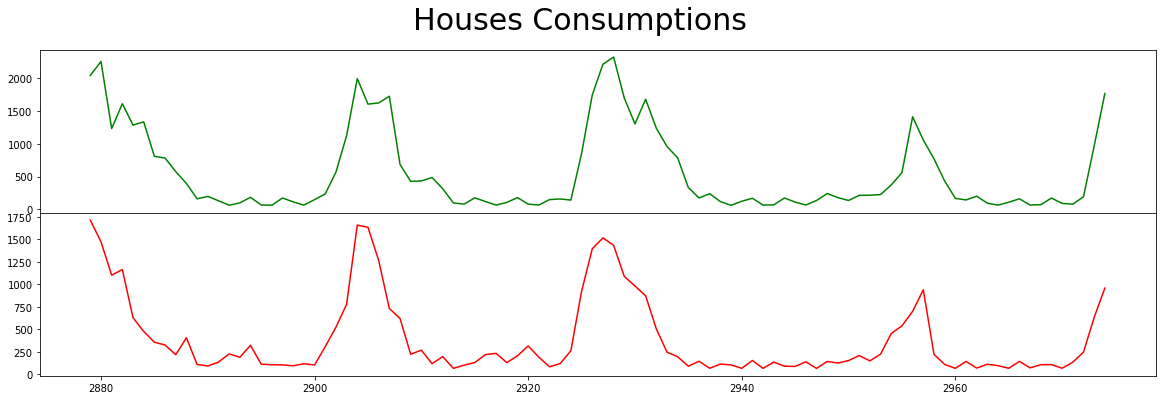

In [220]:
fig, axs = plt.subplots(2, sharex=False, gridspec_kw={"hspace": 0})
plt.suptitle("Houses Consumptions", fontsize="30")

axs[0].plot(heads[f'H_{min_i}'].iloc[idx:idx+m, 1], color = 'green')
axs[1].plot(tails[f'T_{min_j}'].iloc[match_idx:match_idx+m, 1], color = 'red')

## References

[1] Zhu, Y. et al. (2020) “The Swiss army knife of time series data mining: ten useful things you can do with the matrix profile and ten lines of code,” Data Mining and Knowledge Discovery. Springer Science and Business Media LLC, 34(4), pp. 949–979. doi: 10.1007/s10618-019-00668-6.

[2] Murray, D., Stankovic, L. and Stankovic, V., 2017. An electrical load measurements dataset of United Kingdom households from a two-year longitudinal study. Scientific data, 4(1), pp.1-12.